# Time Modifiers Compared

In [26]:
from scripts.imports import *

df_ph = pd.read_csv(paths['phrase_dataset'], index_col='node', low_memory=False)

# selection criteria
df_sgph = df_ph[
    (df_ph.n_heads == 1) # keep to simple phrases
    & (df_ph.n_phatoms == 1)
    & (df_ph.function != 'Spec') # ignore cuz N=2
    & (df_ph.heads_POS != 'PREP') # ignore prep-only phrases
    & (~df_ph.heads_etcbc.str.match('.*\[')) # ignore verbs
].copy()

out = Exporter(
    paths['outdir'], 
    'time_modis'
)

In [78]:
out.number(
    df_sgph.shape[0],
    'N_modexp_af'
)

'84,597'

In [28]:
df_sgph.columns

Index(['verse', 'book', 'booksuper', 'canon_part', 'period', 'heads_etcbc',
       'heads_utf8', 'heads_utf8d', 'heads_POS', 'Phrase Heads', 'function',
       'text', 'types', 'n_heads', 'word_lexs', 'n_words', 'n_phatoms',
       'clause_node', 'firstw', 'genre', 'domain', 'gendom', 'clause',
       'sentence', 'cl_rela', 'cl_type', 'cl_kind', 'verb', 'verb_etcbc',
       'verb_utf8', 'verb_text', 'verbform', 'verb_stem', 'cl_type2', 'PP',
       'unmodified', 'modtag', 'modtag2', 'PL', 'ØPP', 'PARA', 'DEF', 'GP',
       'main_genre', 'NUM', 'SPEC', 'ADJV', 'SFX3', 'SFX', 'APPO', 'QUANT',
       'SFX1', 'SFX2', 'ORDN', 'DU', 'CARDC', 'DEMON', 'HLOC', 'TIMEAPPO',
       'ADVB'],
      dtype='object')

## Identify Nominalization Threshold

In [29]:
lex_hasnom_ct = pivot_ct(
    df_sgph,
    ['heads_etcbc','heads_utf8'],
    ['unmodified'],
)

lex_hasnom_ct = lex_hasnom_ct.set_axis(['yes', 'no'], 1)
lex_hasnom_ct.columns.name = 'noun-modified'

lex_hasnom_pr = lex_hasnom_ct.div(lex_hasnom_ct.sum(1), 0)

In [30]:
out.table(
    lex_hasnom_ct.droplevel('heads_etcbc',0)\
        .rename_axis(index='head lexeme')\
        .head(15).T,
    'all_nounmod_ct',
    caption='Lexeme Noun-modification Frequencies',
    adjustbox=True,
    hebaxis=1,
)

head lexeme,\texthebrew{יְהוָה},\texthebrew{בֵּן},\texthebrew{יֹום},\texthebrew{אֶרֶץ},\texthebrew{אִישׁ},\texthebrew{יָד},\texthebrew{בַּיִת},\texthebrew{דָּבָר},\texthebrew{עַם},\texthebrew{מֶלֶךְ},\texthebrew{הוּא},\texthebrew{אֱלֹהִים},\texthebrew{שָׁם},\texthebrew{שֵׁם},\texthebrew{אֲנִי}
noun-modified,,,,,,,,,,,,,,,
yes,171,1684,1675,1537,885,1193,1110,1033,1086,925,34,920,146,725,45
no,3170,80,26,119,595,44,55,125,66,78,933,0,664,26,697


In [31]:
out.number(
    lex_hasnom_ct.shape[0],
    'all_N_lexs'
)

'4,410'

In [32]:
out.table(
    lex_hasnom_pr.droplevel('heads_etcbc',0)\
        .rename_axis(index='head lexeme')\
        .head(15).T\
        .mul(100).round().astype(int).astype(str) + '%',
    'all_nounmod_pc',
    caption='Lexeme Noun-modification Percentages',
    adjustbox=True,
    hebaxis=1,
)

head lexeme,\texthebrew{יְהוָה},\texthebrew{בֵּן},\texthebrew{יֹום},\texthebrew{אֶרֶץ},\texthebrew{אִישׁ},\texthebrew{יָד},\texthebrew{בַּיִת},\texthebrew{דָּבָר},\texthebrew{עַם},\texthebrew{מֶלֶךְ},\texthebrew{הוּא},\texthebrew{אֱלֹהִים},\texthebrew{שָׁם},\texthebrew{שֵׁם},\texthebrew{אֲנִי}
noun-modified,,,,,,,,,,,,,,,
yes,5%,95%,98%,93%,60%,96%,95%,89%,94%,92%,4%,100%,18%,97%,6%
no,95%,5%,2%,7%,40%,4%,5%,11%,6%,8%,96%,0%,82%,3%,94%


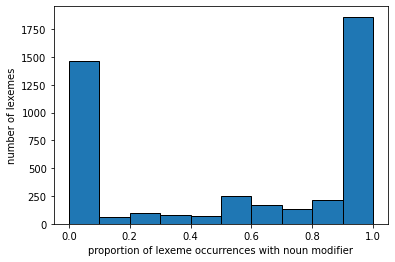

In [79]:
fig, ax = plt.subplots()
lex_hasnom_pr['yes'].plot(kind='hist', edgecolor='black')
ax.set_xlabel('Proportion of Lexeme Occurrences with Noun Modifier'.lower())
ax.set_ylabel('number of lexemes')
out.plot(
    'hist_all_nounmod'
)

**Threshold >= 0.5**

## Apply ΔP Modifier Tests on selected set

In [34]:
threshold = lex_hasnom_pr[lex_hasnom_pr['yes'] >= 0.5].index.droplevel('heads_utf8')

In [35]:
lex_hasnom_ct

,noun-modified,yes,no
heads_etcbc,heads_utf8,,
JHWH/,יְהוָה,171,3170
BN/,בֵּן,1684,80
JWM/,יֹום,1675,26
>RY/,אֶרֶץ,1537,119
>JC/,אִישׁ,885,595
...,...,...,...
MCLXT/,מִשְׁלַחַת,0,1
MCM</,מִשְׁמָע,1,0
MCMNH/,מִשְׁמַנָּה,0,1


In [36]:
th_df = df_sgph[df_sgph.heads_etcbc.isin(threshold)] # threshold DF

out.number(
    th_df.heads_etcbc.unique().shape[0],
    'all_N_thresh',
)

'2,631'

In [37]:
out.number(
    th_df.shape[0],
    'all_ph_thresh_N'
)

'57,945'

In [82]:
mod_ct = pivot_ct(
    th_df,
    'function',
    'modtag2',
)

out.table(
    mod_ct.iloc[:, :10].rename_axis(columns='modifiers'),
    'functmod_ct_10',
    caption='Modifier Counts by Frequency (top 10 modifiers)',
    adjustbox=True,
)

modifiers,SFX,C,DEF,Ø,PL,PL+SFX,PL+C,DEF+PL,DEMON,NUM+PL
function,,,,,,,,,,
Subj,2739,2189,2139,2443,1883,882,1164,610,155,121
Objc,3114,1910,1334,2815,1175,1044,738,355,198,137
Cmpl,2625,2611,3019,1180,444,906,727,711,211,24
PreC,746,1560,756,1460,590,171,432,182,27,118
Adju,909,1080,849,832,268,351,262,239,60,25
Time,37,202,548,169,28,40,42,25,438,205
Loca,139,419,514,99,22,34,56,82,33,0
Modi,4,20,19,89,7,0,2,1,0,34


In [51]:
# ts.show(
#     th_df[
#         (th_df.function == 'Subj')
#         & (th_df.modtag2 == 'Ø')
#     ],
#     extra=['text', 'heads_etcbc', 'ADJV']
# )

In [40]:
mod_ct.sum()

modtag2
SFX                10313
C                   9991
DEF                 9178
Ø                   9087
PL                  4417
PL+SFX              3428
PL+C                3423
DEF+PL              2205
DEMON               1122
NUM+PL               664
NUM                  589
KL+DEF               457
KL+PL+C              360
KL+C                 319
KL                   317
KL+PL+SFX            290
KL+DEF+PL            253
ORDN                 226
KL+SFX               190
PL+DEMON             176
NUM+PL+C             122
KL+PL                 98
NUM+DEF+PL            95
PL+QUANT              92
QUANT                 69
KL+PL+DEMON           59
QUANT+DEF             54
NUM+PL+SFX            48
KL+DEMON              38
QUANT+PL+SFX          35
QUANT+SFX             34
QUANT+PL              28
QUANT+PL+C            20
NUM+PL+DEMON          16
NUM+DEF               16
QUANT+C               16
NUM+SFX               14
NUM+C                 14
QUANT+DEF+PL          11
DEF+NUM          

In [41]:
# N unique mod tags
out.number(
    mod_ct.shape[1],
    'N_unique_modtag'
)

'55'

In [52]:
# N unique mod tags
out.number(
    mod_ct.sum().sum(),
    'N_observed_phs'
)

'57,945'

In [53]:
top_time_mods = mod_ct.loc['Time'].sort_values(ascending=False)

top_time_mods.head(10)

modtag2
DEF          548
DEMON        438
NUM+PL       205
C            202
Ø            169
ORDN         160
NUM          156
PL+DEMON      55
KL+DEF        52
KL+DEF+PL     45
Name: Time, dtype: int64

Text(0.5, 0, 'modifier tag')

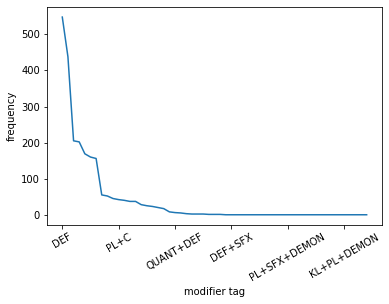

In [54]:
fig, ax = plt.subplots()
top_time_mods.plot(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_ylabel('frequency')
ax.set_xlabel('modifier tag')

In [55]:
mod_dp = sig.apply_deltaP(mod_ct, 0, 1)

mod_dp

modtag2,SFX,C,DEF,Ø,PL,PL+SFX,PL+C,DEF+PL,DEMON,NUM+PL,...,PL+SFX+NUM,KL+DEF+PL+C,DEF+C,KL+PL+NUM,PL+SFX+ORDN,QUANT+DEMON,KL+PL+ORDN,DEF+PL+SFX,SFX+NUM,KL+PL+SFX+DEMON
function,,,,,,,,,,,,,,,,,,,,,
Subj,0.000606,-0.040575,-0.025919,0.003158,0.063171,-0.002318,0.022790,0.002290,-0.012606,-0.004866,...,0.000042,-0.000047,-0.000047,0.000042,0.000065,-0.000023,-0.000023,-0.000023,0.000065,0.000065
Objc,0.062516,-0.044693,-0.081054,0.061854,0.011682,0.021628,-0.007360,-0.016191,-0.006588,-0.002013,...,0.000050,0.000050,-0.000045,-0.000045,-0.000023,0.000072,0.000072,-0.000023,-0.000023,-0.000023
Cmpl,0.029349,0.035143,0.093553,-0.086015,-0.054605,0.013060,-0.004505,0.021063,-0.004172,-0.012430,...,-0.000045,-0.000045,0.000153,-0.000045,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022
PreC,-0.068714,0.080804,-0.044941,0.080736,0.018180,-0.036388,0.009648,-0.010732,-0.017009,0.007891,...,-0.000039,-0.000039,-0.000039,0.000137,-0.000019,-0.000019,-0.000019,0.000157,-0.000019,-0.000019
Adju,-0.007371,0.034216,0.001746,-0.000052,-0.028322,0.007683,-0.010683,0.007685,-0.008870,-0.007429,...,-0.000038,0.000169,-0.000038,-0.000038,-0.000019,-0.000019,-0.000019,-0.000019,-0.000019,-0.000019
Time,-0.168890,-0.089318,0.080019,-0.087820,-0.066900,-0.043751,-0.042767,-0.028468,0.175684,0.079730,...,-0.000036,-0.000036,-0.000036,-0.000036,-0.000018,-0.000018,-0.000018,-0.000018,-0.000018,-0.000018
Loca,-0.087903,0.108809,0.188020,-0.093468,-0.063252,-0.037543,-0.022447,0.016870,0.002632,-0.011765,...,-0.000035,-0.000035,-0.000035,-0.000035,-0.000018,-0.000018,-0.000018,-0.000018,-0.000018,-0.000018
Modi,-0.156858,-0.064520,-0.055867,0.325299,-0.038513,-0.059349,-0.048417,-0.032752,-0.019425,0.172877,...,-0.000035,-0.000035,-0.000035,-0.000035,-0.000017,-0.000017,-0.000017,-0.000017,-0.000017,-0.000017


In [71]:
# narrow down to top time mods
mod_dp2 = mod_dp[top_time_mods.index]

mod_dp2.head()

modtag2,DEF,DEMON,NUM+PL,C,Ø,ORDN,NUM,PL+DEMON,KL+DEF,KL+DEF+PL,...,NUM+SFX,QUANT+C,NUM+DEF,NUM+PL+DEMON,QUANT+SFX,KL+PL+DEMON,QUANT,KL+PL,KL+C,KL+PL+SFX+DEMON
function,,,,,,,,,,,,,,,,,,,,,
Subj,-0.025919,-0.012606,-0.004866,-0.040575,0.003158,-0.003534,-0.004966,-0.001296,0.004868,-0.001597,...,0.000026,0.000156,0.000067,0.000156,-0.000532,-0.000765,-0.000291,0.001953,0.001727,0.000065
Objc,-0.081054,-0.006588,-0.002013,-0.044693,0.061854,-0.004169,-0.003643,0.000388,-0.001128,-0.000406,...,-0.000127,0.000018,-0.000077,0.000018,-0.000105,0.002467,-0.000137,-0.000318,0.000762,-0.000023
Cmpl,0.093553,-0.004172,-0.012430,0.035143,-0.086015,-0.004642,-0.009178,-0.002244,-0.002879,-0.000208,...,-0.000115,0.000038,-0.000159,0.000236,-0.000264,-0.000723,-0.000847,-0.001098,-0.000790,-0.000022
PreC,-0.044941,-0.017009,0.007891,0.080804,0.080736,-0.000511,0.013042,-0.002357,-0.004463,-0.002971,...,0.000257,0.000042,0.000394,-0.000310,-0.000483,-0.001144,0.001830,-0.001373,-0.003723,-0.000019
Adju,0.001746,-0.008870,-0.007429,0.034216,-0.000052,-0.002634,-0.001855,0.000390,-0.004741,0.001209,...,0.000149,-0.000304,0.000111,-0.000304,0.003088,0.000124,0.001386,0.000213,-0.000045,-0.000019


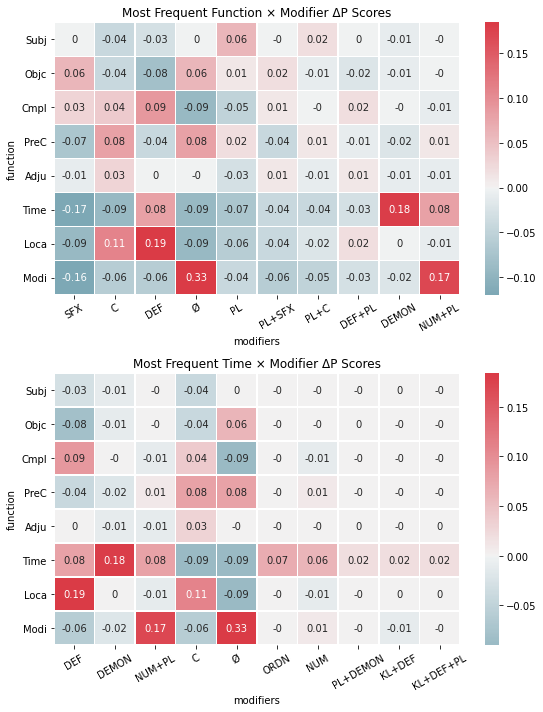

In [99]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

titles = [
    'Most Frequent Function × Modifier ΔP Scores',
    'Most Frequent Time × Modifier ΔP Scores',
]

for i, dpdata in enumerate([mod_dp, mod_dp2]):
    ax = axs[i]
    heatmap(dpdata.round(2).iloc[:,:10], ax=ax, square=False, robust=True, annot=True)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_xlabel('modifiers')
    ax.set_title(titles[i])
    
fig.tight_layout()

out.plot(
    'heat_dp_fmodall'
    
)

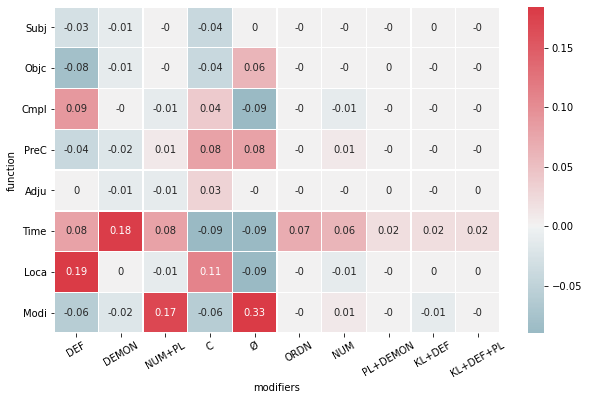

In [101]:
fig, ax = plt.subplots(figsize=(10, 6))

heatmap(dpdata.round(2).iloc[:,:10], ax=ax, square=False, robust=True, annot=True)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel('modifiers')

out.plot(
    'heat_dp_fmodtime'
    
)

## Pull out numbers

In [103]:
out.number(
    mod_dp['DEMON']['Time'] * 100,
    'dp_time_demon',
)

'18'

In [136]:
time_ex = df_sg[
        (df_sg.times_etcbc.isin(threshold))
        & (df_sg.cl_kind == 'VC')
        & (~df_sg.cl_type2.isin(['WayH', 'WQtH']))
]

out.examples(
    time_ex[time_ex.modtag2 == 'DEMON'].sample(5, random_state=42),
    'ex_demon_time',
)

,verse,clause
node,,
505497,Esth 3:14,לִהְיֹ֥ות עֲתִדִ֖ים לַיֹּ֥ום הַזֶּֽה׃
440325,Lev 23:21,וּקְרָאתֶ֞ם בְּעֶ֣צֶם׀ הַיֹּ֣ום הַזֶּ֗ה
433180,Gen 47:26,וַיָּ֣שֶׂם אֹתָ֣הּ יֹוסֵ֡ף לְחֹק֩ עַד־הַיֹּ֨ום...
489768,Zech 12:9,בַּיֹּ֣ום הַה֑וּא אֲבַקֵּ֗שׁ
445576,Deut 5:24,הַיֹּ֤ום הַזֶּה֙ רָאִ֔ינוּ


In [144]:
out.number(
    mod_dp['DEF']['Time'] * 100,
    'dp_time_def',
)

'8'

In [143]:
out.examples(
    time_ex[time_ex.modtag2 == 'DEF'].sample(5, random_state=69),
    'ex_def_time',
)

,verse,clause
node,,
478376,Jer 40:4,הִנֵּ֧ה פִתַּחְתִּ֣יךָ הַיֹּ֗ום מִֽן־הָאזִקִּים֮
443022,Num 19:10,וְטָמֵ֖א עַד־הָעָ֑רֶב
464167,1 Kgs 20:13,הִנְנִ֨י נֹתְנֹ֤ו בְיָֽדְךָ֙ הַיֹּ֔ום
436689,Exod 29:39,וְאֵת֙ הַכֶּ֣בֶשׂ הַשֵּׁנִ֔י תַּעֲשֶׂ֖ה בֵּ֥ין...
453616,Judg 19:27,וַיָּ֨קָם אֲדֹנֶ֜יהָ בַּבֹּ֗קֶר


In [149]:
out.number(
    mod_dp['ORDN']['Time'] * 100,
    'dp_time_ordn',
)

'7'

In [150]:
out.examples(
    time_ex[time_ex.modtag2 == 'ORDN'].sample(5, random_state=69),
    'ex_ordn_time',
)

,verse,clause
node,,
434791,Exod 12:16,וּבַיֹּום֙ הַשְּׁבִיעִ֔י מִקְרָא־קֹ֖דֶשׁ יִהְי...
439076,Lev 13:27,וְרָאָ֥הוּ הַכֹּהֵ֖ן בַּיֹּ֣ום הַשְּׁבִיעִ֑י
439108,Lev 13:34,וְרָאָה֩ הַכֹּהֵ֨ן אֶת־הַנֶּ֜תֶק בַּיֹּ֣ום הַש...
435371,Exod 16:27,בַּיֹּ֣ום הַשְּׁבִיעִ֔י יָצְא֥וּ מִן־הָעָ֖ם
515060,2 Chr 31:7,וּבַחֹ֥דֶשׁ הַשְּׁבִיעִ֖י כִּלּֽוּ׃ ס


In [151]:
out.number(
    mod_dp['NUM']['Time'] * 100,
    'dp_time_num',
)

'6'

In [157]:
out.examples(
    time_ex[
        (time_ex.modtag2 == 'NUM')
        & (time_ex.function == 'atelic_ext')
    ].sample(3, random_state=42069),
    'ex_numatel_time',
)

,verse,clause
node,,
483274,Ezek 29:12,וְעָרֶ֨יהָ֙ בְּתֹ֨וךְ עָרִ֤ים מָֽחֳרָבֹות֙ תִּ...
465006,2 Kgs 3:1,וַיִּמְלֹ֖ךְ שְׁתֵּים־עֶשְׂרֵ֥ה שָׁנָֽה׃
515341,2 Chr 34:1,וּשְׁלֹשִׁ֤ים וְאַחַת֙ שָׁנָ֔ה מָלַ֖ךְ בִּירוּ...


In [167]:
out.examples(
    df[
        (df.modtag2 == 'NUM')
        & (df.function == 'simultaneous_calendar')
    ].sample(3, random_state=69),
    'ex_numsim_time',
)

,verse,clause
node,,
483731,Ezek 33:21,וַיְהִ֞י בִּשְׁתֵּ֧י עֶשְׂרֵ֣ה שָׁנָ֗ה בָּעֲשׂ...
463001,1 Kgs 12:33,וַיַּ֜עַל עַֽל־הַמִּזְבֵּ֣חַ׀ בַּחֲמִשָּׁ֨ה עָ...
478301,Jer 39:2,בְּעַשְׁתֵּֽי־עֶשְׂרֵ֤ה שָׁנָה֙ לְצִדְקִיָּ֔הו...


In [172]:
out.number(
    mod_dp['NUM+PL']['Time'] * 100,
    'dp_time_numpl',
)

'8'

In [171]:
out.examples(
    time_ex[
        (time_ex.modtag2 == 'NUM+PL')
    ].sample(3, random_state=69),
    'ex_plnum_time',
)

,verse,clause
node,,
457953,1 Sam 31:13,וַיָּצֻ֖מוּ שִׁבְעַ֥ת יָמִֽים׃ פ
444093,Num 28:17,שִׁבְעַ֣ת יָמִ֔ים מַצֹּ֖ות יֵאָכֵֽל׃
445541,Deut 5:13,שֵׁ֤֣שֶׁת יָמִ֣ים֙ תַּֽעֲבֹ֔ד֮


In [93]:
# count heads with functs to see if ELOHIM is 
# responsible for higher PL score with Subj
headfunct_ct = pivot_ct(
    th_df,
    'function',
    'heads_utf8',
)

headfunct_pr = headfunct_ct.div(headfunct_ct.sum(1), 0)

In [94]:
headfunct_pr.loc['Subj'].sort_values(ascending=False).head(20)

heads_utf8
אִישׁ       0.056739
בֵּן        0.049313
מֶלֶךְ      0.033157
אֱלֹהִים    0.027946
עַם         0.027751
דָּבָר      0.023060
אַתֶּם      0.016546
שֵׁם        0.016416
הֵמָּה      0.015699
כֹּהֵן      0.015308
אֶרֶץ       0.014592
נֶפֶשׁ      0.013680
הֵם         0.013419
אֲדֹנָי     0.012963
יָד         0.012507
יֹום        0.011986
לֵב         0.011856
כֹּל        0.011465
עַיִן       0.011400
אָב         0.010488
Name: Subj, dtype: float64

In [96]:
out.number(
    headfunct_pr.loc['Subj']['אֱלֹהִים']*100,
    'subj_elohim_pc',
)

'3'

In [86]:
ts.show(
    df_sgph[
        (df_sgph.heads_etcbc.isin(threshold))
        & (df_sgph.function == 'Subj')
        & (df_sgph.modtag2 == 'PL')
    ]
, extra=['text'])

showing 25 of 1883


,verse,clause,text
node,,,
651544,Gen 1:1,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃,אֱלֹהִ֑ים
657040,Gen 20:13,כַּאֲשֶׁ֧ר הִתְע֣וּ אֹתִ֗י אֱלֹהִים֮ מִבֵּ֣ית אָבִי֒,אֱלֹהִים֮
666247,Gen 42:19,אִם־כֵּנִ֣ים אַתֶּ֔ם,אַתֶּ֔ם
675667,Exod 18:22,וְכָל־הַדָּבָ֥ר הַקָּטֹ֖ן יִשְׁפְּטוּ־הֵ֑ם,הֵ֑ם
696787,Num 14:27,אֲשֶׁ֛ר הֵ֥מָּה מַלִּינִ֖ים עָלָ֑י,הֵ֥מָּה
708353,Deut 12:1,אֲשֶׁר־אַתֶּ֥ם חַיִּ֖ים עַל־הָאֲדָמָֽה׃,אַתֶּ֥ם
724417,Judg 5:4,גַּם־עָבִ֖ים נָ֥טְפוּ מָֽיִם׃,גַּם־עָבִ֖ים
732881,1 Sam 4:7,בָּ֥א אֱלֹהִ֖ים אֶל־הַֽמַּחֲנֶ֑ה,אֱלֹהִ֖ים
743736,1 Sam 31:8,וַיָּבֹ֣אוּ פְלִשְׁתִּ֔ים,פְלִשְׁתִּ֔ים


In [249]:
ts.show(
    df_sgph[
        (df_sgph.heads_etcbc.isin(threshold))
        & (df_sgph.function == 'Cmpl')
        & (df_sgph.modtag2 == 'DEF')
    ]
, extra=['text'])

showing 25 of 3194


,verse,clause,text
node,,,
651578,Genesis 1:5,וַיִּקְרָ֨א אֱלֹהִ֤ים׀ לָאֹור֙ יֹ֔ום,לָאֹור֙
658803,Genesis 24:61,וַתֵּלַ֖כְנָה אַחֲרֵ֣י הָאִ֑ישׁ,אַחֲרֵ֣י הָאִ֑ישׁ
674030,Exodus 14:5,וַ֠יֵּהָפֵךְ לְבַ֨ב פַּרְעֹ֤ה וַעֲבָדָיו֙ אֶל־הָעָ֔ם,אֶל־הָעָ֔ם
682693,Exodus 40:32,וּבְקָרְבָתָ֛ם אֶל־הַמִּזְבֵּ֖חַ,אֶל־הַמִּזְבֵּ֖חַ
687063,Leviticus 14:16,וְהִזָּ֨ה מִן־הַשֶּׁ֧מֶן בְּאֶצְבָּעֹ֛ו שֶׁ֥בַע פְּעָמִ֖ים לִפְנֵ֥י יְהוָֽה׃,מִן־הַשֶּׁ֧מֶן
694388,Numbers 7:37,בְּלוּלָ֥ה בַשֶּׁ֖מֶן,בַשֶּׁ֖מֶן
702299,Numbers 31:12,וַיָּבִ֡אוּ אֶל־מֹשֶׁה֩ וְאֶל־אֶלְעָזָ֨ר הַכֹּהֵ֜ן וְאֶל־עֲדַ֣ת בְּנֵֽי־יִשְׂרָאֵ֗ל אֶת־הַשְּׁבִ֧י וְאֶת־הַמַּלְקֹ֛וחַ וְאֶת־הַשָּׁלָ֖ל אֶל־הַֽמַּחֲנֶ֑ה אֶל־עַֽרְבֹ֣ת מֹואָ֔ב,אֶל־הַֽמַּחֲנֶ֑ה
711728,Deuteronomy 23:11,לֹ֥א יָבֹ֖א אֶל־תֹּ֥וךְ הַֽמַּחֲנֶֽה׃,אֶל־תֹּ֥וךְ הַֽמַּחֲנֶֽה׃
718212,Joshua 8:22,וַיִּֽהְי֤וּ לְיִשְׂרָאֵל֙ בַּתָּ֔וֶךְ,בַּתָּ֔וֶךְ


In [241]:
mod_dp.loc['Time'][mod_dp.loc['Time'].index.str.match('DEF')]

modtag2
DEF           0.051544
DEF+PL       -0.020014
DEF+NUM       0.000171
DEF+SFX      -0.000049
DEF+C         0.000269
DEF+PL+C     -0.000012
DEF+PL+SFX   -0.000012
Name: Time, dtype: float64

## By Main Genre

In [173]:
# lex_nomgen_ct = pivot_ct(
#     df_sgph[df_sgph.heads_etcbc.isin(threshold)],
#     ['function', 'main_genre'],
#     ['modtag2'],
# )

# lex_nomgen_ct